In [38]:
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split # k-fold CV
from sklearn.model_selection import GridSearchCV

In [2]:
champ_df = pd.read_csv('LoL_Data/champion_stats.csv')
player_df = pd.read_csv('LoL_Data/player_stats.csv')
match_df = pd.read_csv('LoL_Data/match_stats.csv')

In [3]:
# make new dataframe with as much relevant data as possible including target.
def wrangle(df):
    cutoff = 50
    p = "(ban|pick)"
    pa = "(kill_death_assist_ratio|win_rate)"
    drop_cols = []
    df = df.loc[df['event'] == 'Main']

    drop_cols.append('event')

    for col in df.columns:
        if col == 'date':
            drop_cols.append(col)
        elif re.match(p, col) != None:
            drop_cols.append(col)
        elif re.fullmatch(pa, col) != None:
            drop_cols.append(col)
        elif df[col].isnull().sum() > cutoff:
            drop_cols.append(col)

    df.drop(columns=drop_cols, inplace=True)

    return df

In [4]:
def set_season(df, season):
    return df[df['season'] == season]


In [5]:
mdf = wrangle(match_df)
pdf = wrangle(player_df)

C:\Users\Jak\AppData\Local\Temp\ipykernel_27876\3680867569.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=drop_cols, inplace=True)
C:\Users\Jak\AppData\Local\Temp\ipykernel_27876\3680867569.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=drop_cols, inplace=True)


In [6]:
# This is all info I want to use so we'll join pdf info here on season
mdf.columns

Index(['season', 'blue_team', 'red_team', 'winner', 'top_blue_team',
       'jungler_blue_team', 'mid_blue_team', 'adc_blue_team',
       'support_blue_team', 'top_red_team', 'jungler_red_team', 'mid_red_team',
       'adc_red_team', 'support_red_team'],
      dtype='object')

In [7]:
# I want team, player, gold/min from pdf
pdf.columns

Index(['season', 'team', 'player', 'games_played', 'wins', 'loses', 'kills',
       'deaths', 'assists', 'creep_score', 'cs/min', 'gold', 'gold/min'],
      dtype='object')

In [46]:
season = 8

season_players, season_matches = set_season(pdf, season), set_season(mdf, season)

In [47]:
for col in season_players.columns:
    if col in ['team', 'player', 'gold/min']:
        continue
    else:
        season_players.drop(columns=col, inplace=True)

C:\Users\Jak\AppData\Local\Temp\ipykernel_27876\1819096043.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_players.drop(columns=col, inplace=True)
C:\Users\Jak\AppData\Local\Temp\ipykernel_27876\1819096043.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_players.drop(columns=col, inplace=True)
C:\Users\Jak\AppData\Local\Temp\ipykernel_27876\1819096043.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_playe

In [48]:
# gunna add a 'blue_win' binary column. if blue team won give them a 1 else 0

season_matches['blue_win'] = 0

for match in season_matches.index:
    if season_matches['blue_team'][match] == season_matches['winner'][match]:
        season_matches['blue_win'][match] = 1

C:\Users\Jak\AppData\Local\Temp\ipykernel_27876\4059807213.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_matches['blue_win'] = 0
C:\Users\Jak\AppData\Local\Temp\ipykernel_27876\4059807213.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_matches['blue_win'][match] = 1


In [49]:
# now that we've made a season, 'player' is a unique value suited to indexing
season_players.set_index('player', inplace=True)

In [50]:
# matches will keep a normal index for convienience

season_matches.drop(columns=['season', 'red_team', 'blue_team', 'winner'], inplace=True)

C:\Users\Jak\AppData\Local\Temp\ipykernel_27876\3860201109.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_matches.drop(columns=['season', 'red_team', 'blue_team', 'winner'], inplace=True)


In [51]:
season_players.columns

Index(['team', 'gold/min'], dtype='object')

In [52]:
season_matches.columns

Index(['top_blue_team', 'jungler_blue_team', 'mid_blue_team', 'adc_blue_team',
       'support_blue_team', 'top_red_team', 'jungler_red_team', 'mid_red_team',
       'adc_red_team', 'support_red_team', 'blue_win'],
      dtype='object')

In [53]:
# this method struggled because players that appeared in multiple seasons have multiple values. 
# This probably leaked in with the team gold stats from before as well. Hence the new set_season()

for match in season_matches.index:
    for col in season_matches:
        if col == 'blue_win':
            continue
        elif season_matches[col][match].strip() in season_players.index:
            season_matches[col][match] = season_players.at[season_matches[col][match].strip(), 'gold/min']

C:\Users\Jak\AppData\Local\Temp\ipykernel_27876\1155664163.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_matches[col][match] = season_players.at[season_matches[col][match].strip(), 'gold/min']


In [54]:
season_matches.head()

,top_blue_team,jungler_blue_team,mid_blue_team,adc_blue_team,support_blue_team,top_red_team,jungler_red_team,mid_red_team,adc_red_team,support_red_team,blue_win
511,443,365,418,466,258,359,362,411,460,254,1
512,394,362,411,460,254,443,365,418,466,258,0
513,394,362,411,460,254,443,365,418,466,258,0
514,394,362,411,460,254,364,345,401,415,248,1
515,364,345,401,415,248,394,362,411,460,254,0


Some Old Code from the initial forest premise measuring side and position importances. Results were... don't worry about it.

In [55]:
# my first forest fits based on solely team and player names was very over-fit and mostly showed a very slight skew towards to blue team. (test score: .93, val score: .47)
# Most positions registered as either equally important or with somewhat declining importance (almost exclusively biased against the red team) 

# Time to try with the second run. team's average gold/min. I expect similar results.

In [56]:
'''
for match in mdf2.index:
    if mdf2['red_team'][match] in gold_df.index:
        mdf2['red_team'][match] = gold_df.at[mdf2['red_team'][match], 'team_gold']
    if mdf2['blue_team'][match] in gold_df.index:
        mdf2['blue_team'][match] = gold_df.at[mdf2['blue_team'][match], 'team_gold']
    if mdf2['winner'][match] in gold_df.index:
        mdf2['winner'][match] = gold_df.at[mdf2['winner'][match], 'team_gold']


for match in mdf2.index:
    for col in mdf2.columns:
        if type(mdf2[col][match]) == str:
            if mdf2[col][match].strip() in pdf.index:
                mdf2[col][match] = pdf.at[mdf2[col][match].strip(), 'gold/min']

target = 'winner'

y = mdf2[target]
X = mdf2.drop(columns=target)
'''

"\nfor match in mdf2.index:\n    if mdf2['red_team'][match] in gold_df.index:\n        mdf2['red_team'][match] = gold_df.at[mdf2['red_team'][match], 'team_gold']\n    if mdf2['blue_team'][match] in gold_df.index:\n        mdf2['blue_team'][match] = gold_df.at[mdf2['blue_team'][match], 'team_gold']\n    if mdf2['winner'][match] in gold_df.index:\n        mdf2['winner'][match] = gold_df.at[mdf2['winner'][match], 'team_gold']\n\n\nfor match in mdf2.index:\n    for col in mdf2.columns:\n        if type(mdf2[col][match]) == str:\n            if mdf2[col][match].strip() in pdf.index:\n                mdf2[col][match] = pdf.at[mdf2[col][match].strip(), 'gold/min']\n\ntarget = 'winner'\n\ny = mdf2[target]\nX = mdf2.drop(columns=target)\n"

In [57]:
# alright, now that the players have stats, I want to try classifying the winner based on the numbers rather than just the names?
# not really sure how to do that at this exact moment. Might text Fabiola
# check for linear regression correlation between gold and position? 
# May not be helpful as this is effectively asking 'do positions make different amounts' (should be true)

# Stretch Note:
# maybe I should just run the numbers on each position?
# Maybe mark which number won and see if a pattern emerges for any position. 

In [58]:
target = 'blue_win'

y = season_matches[target]
X = season_matches.drop(columns=target)

In [59]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
model_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state=42)
)

model_rf.fit(X_train, y_train);

c:\Users\Jak\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\utils.py:360: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


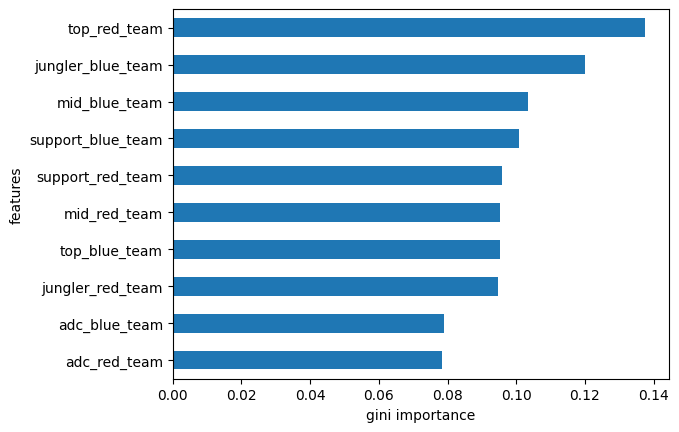

In [61]:
features = model_rf.named_steps['ordinalencoder'].get_feature_names()
gini = model_rf.named_steps['randomforestclassifier'].feature_importances_
pd.Series(data=gini, index=features).sort_values(key=abs).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance');

In [62]:
# some basic cv
model_rf_scores = cross_val_score(model_rf, X, y, cv=5)

In [63]:
# hey one of these spit out a .83 !
model_rf_scores

array([0.5       , 0.5       , 0.66666667, 0.53333333, 0.6       ])

In [64]:
# some more rigor please

param_grid = {
    'randomforestclassifier__max_depth': range(5,40,5),
    'randomforestclassifier__n_estimators': range(25,125,25)
}

In [65]:
model_rf_gs = GridSearchCV(model_rf,
             param_grid=param_grid,
             cv=5,
             verbose=1)

model_rf_gs.fit(X,y)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=['top_blue_team',
                                                             'jungler_blue_team',
                                                             'mid_blue_team',
                                                             'adc_blue_team',
                                                             'support_blue_team',
                                                             'top_red_team',
                                                             'jungler_red_team',
                                                             'mid_red_team',
                                                             'adc_red_team',
                                                             'support_red_team'],
                                                       mapping=[{'col': 'top_blue_team',
                                                                 'data_type': dtype('O'),
                                                                 'mapping': 366.0     1
394.0     2
368.0     3
410.0     4
342.0     5...
                                                                 'data_type': dtype('O'),
                                                                 'mapping': 254.0     1
248.0     2
246.0     3
258.0     4
204.0     5
226.0     6
232.0     7
231.0     8
198.0     9
237.0    10
241.0    11
236.0    12
227.0    13
233.0    14
244.0    15
228.0    16
NaN      -2
dtype: int64}])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'randomforestclassifier__max_depth': range(5, 40, 5),
                         'randomforestclassifier__n_estimators': range(25, 125, 25)},
             verbose=1)

In [66]:
model_rf_gs.best_params_

{'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__n_estimators': 100}

In [67]:
model_rf_gs.best_score_

0.6366666666666666

In [68]:
model_rf_gs.best_estimator_

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['top_blue_team', 'jungler_blue_team',
                                      'mid_blue_team', 'adc_blue_team',
                                      'support_blue_team', 'top_red_team',
                                      'jungler_red_team', 'mid_red_team',
                                      'adc_red_team', 'support_red_team'],
                                mapping=[{'col': 'top_blue_team',
                                          'data_type': dtype('O'),
                                          'mapping': 366.0     1
394.0     2
368.0     3
410.0     4
342.0     5
346.0     6
356.0     7
326.0     8
443.0     9
359....
435.0     6
427.0     7
464.0     8
385.0     9
430.0    10
450.0    11
398.0    12
459.0    13
429.0    14
441.0    15
397.0    16
NaN      -2
dtype: int64},
                                         {'col': 'support_red_team',
                                          'data_type': dtype('O'),
                                          'mapping': 254.0     1
248.0     2
246.0     3
258.0     4
204.0     5
226.0     6
232.0     7
231.0     8
198.0     9
237.0    10
241.0    11
236.0    12
227.0    13
233.0    14
244.0    15
228.0    16
NaN      -2
dtype: int64}])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, random_state=42))])

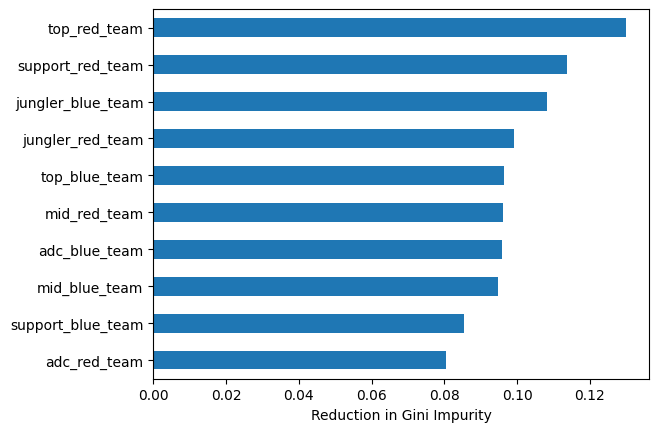

In [69]:
bestestimator = model_rf_gs.best_estimator_
importances = bestestimator.named_steps['randomforestclassifier'].feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Reduction in Gini Impurity');

In [70]:
model_rf_gs.predict(X_val)

array([0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1], dtype=int64)

In [71]:
y_val

515    0
546    1
521    1
511    1
556    1
558    1
577    0
564    1
561    1
539    0
579    0
585    0
529    1
523    0
569    1
544    1
Name: blue_win, dtype: int64

In [72]:
# remember to rename first!!
# path = 'LoL_Models/initial_league_forest'


# to save
# with open(path,'wb') as f:
    # pickle.dump(bestestimator, f)


# to load
# with open(path, 'rb') as f:
    # model_rf_loaded = pickle.load(f)